            +------------+     +---------------+     +-----------+
            | user_data  |     | post_text_df  |     | feed_data |
            +------------+     +---------------+     +-----------+
            | age        |     | id            |     | timestamp |
            | city       |     | text          |     | user_id   |
            | country    |     | topic         |     | post_id   |
            | exp_group  |     +---------------+     | action    |
            | gender     |           7,023           | target    |
            | id         |                           +-----------+
            | os         |                             76,892,800
            | source     |
            +------------+
                163,205 

# Data Preprocessing

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)

# Чтение данных таблицы user_data
query = "SELECT * FROM user_data"
user_data = pd.read_sql(query, engine)

# Чтение данных таблицы post_text_df
query = "SELECT * FROM post_text_df"
post_text_df = pd.read_sql(query, engine)

# Чтение ограниченного количества данных таблицы feed_data
query = "SELECT * FROM feed_data LIMIT 100000"
feed_data = pd.read_sql(query, engine)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pickle


In [4]:
# Переименование столбцов идентификаторов
user_data = user_data.rename(columns={'id': 'user_id'})
post_text_df = post_text_df.rename(columns={'id': 'post_id'})

# Объединение таблиц
data = feed_data.merge(user_data, on='user_id', how='left')
data = data.merge(post_text_df, on='post_id', how='left')


In [5]:
data.head()

,timestamp,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic
0,2021-11-26 17:04:51,30379,2449,view,0,1,23,Ukraine,Sumy,2,iOS,ads,"No matter where you look, you can find info on...",covid
1,2021-11-26 17:05:29,30379,517,view,0,1,23,Ukraine,Sumy,2,iOS,ads,LSE doubts boost bidders shares\n\nShares in D...,business
2,2021-11-26 17:06:30,30379,3489,view,0,1,23,Ukraine,Sumy,2,iOS,ads,Chinese students abroad fall victim to ticket ...,covid
3,2021-11-26 17:09:05,30379,1474,view,0,1,23,Ukraine,Sumy,2,iOS,ads,Benitez deflects blame from Dudek\n\nLiverpool...,sport
4,2021-11-26 17:10:39,30379,6314,view,0,1,23,Ukraine,Sumy,2,iOS,ads,I believe the reason this movie did not get th...,movie


# Ferauture engineering

### Time
Here we will create 3 new feautures from the timestamp:
1. hour_of_day
2. time_since_last_action
3. day_of_week

In [6]:
import pandas as pd

# Convert the timestamp format to a datetime object
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Extract features from the timestamp
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['hour_of_day'] = data['timestamp'].dt.hour

# Calculate the time since the last action for each user
data = data.sort_values(['user_id', 'timestamp'])
data['time_since_last_action'] = data.groupby('user_id')['timestamp'].diff().dt.total_seconds()
data['time_since_last_action'].fillna(0, inplace=True)

# Drop the timestamp column
data = data.drop('timestamp', axis=1)

In [7]:
data.head()

,user_id,post_id,action,target,gender,age,country,city,exp_group,os,source,text,topic,day_of_week,hour_of_day,time_since_last_action
57738,9612,2350,view,1,1,39,Russia,Saint Petersburg,0,Android,ads,The Great British Dilemma...... schools vs pub...,covid,1,14,0.0
57739,9612,2350,like,0,1,39,Russia,Saint Petersburg,0,Android,ads,The Great British Dilemma...... schools vs pub...,covid,1,14,79.0
57740,9612,6078,view,0,1,39,Russia,Saint Petersburg,0,Android,ads,Coming shortly before the imposition of a mora...,movie,1,14,2.0
57741,9612,6544,view,0,1,39,Russia,Saint Petersburg,0,Android,ads,"Well, SWORD IN THE MOON finally got a DVD rele...",movie,1,14,46.0
57742,9612,5533,view,0,1,39,Russia,Saint Petersburg,0,Android,ads,"Why? Because for one reason, there has never b...",movie,1,14,148.0


### One hot encoding

In [8]:
# One-hot encoding for 'country', 'city', and 'topic'
data = pd.get_dummies(data, columns=['country', 'city', 'topic'], prefix=['country', 'city', 'topic'])

In [9]:
data.head()

,user_id,post_id,action,target,gender,age,exp_group,os,source,text,...,city_Zhatay,city_Zlatoust,city_Zvenyhorodka,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
57738,9612,2350,view,1,1,39,0,Android,ads,The Great British Dilemma...... schools vs pub...,...,False,False,False,False,True,False,False,False,False,False
57739,9612,2350,like,0,1,39,0,Android,ads,The Great British Dilemma...... schools vs pub...,...,False,False,False,False,True,False,False,False,False,False
57740,9612,6078,view,0,1,39,0,Android,ads,Coming shortly before the imposition of a mora...,...,False,False,False,False,False,False,True,False,False,False
57741,9612,6544,view,0,1,39,0,Android,ads,"Well, SWORD IN THE MOON finally got a DVD rele...",...,False,False,False,False,False,False,True,False,False,False
57742,9612,5533,view,0,1,39,0,Android,ads,"Why? Because for one reason, there has never b...",...,False,False,False,False,False,False,True,False,False,False


### Label encoding

In [10]:
from sklearn.preprocessing import LabelEncoder

le_gender = LabelEncoder()
le_os = LabelEncoder()
le_source = LabelEncoder()
le_action = LabelEncoder()

# Label encoding for 'gender', 'os', and 'source'
data['gender'] = le_gender.fit_transform(data['gender'])
data['os'] = le_os.fit_transform(data['os'])
data['source'] = le_source.fit_transform(data['source'])
data['action'] = le_action.fit_transform(data['action'])


In [11]:
data.head()

,user_id,post_id,action,target,gender,age,exp_group,os,source,text,...,city_Zhatay,city_Zlatoust,city_Zvenyhorodka,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
57738,9612,2350,1,1,1,39,0,0,0,The Great British Dilemma...... schools vs pub...,...,False,False,False,False,True,False,False,False,False,False
57739,9612,2350,0,0,1,39,0,0,0,The Great British Dilemma...... schools vs pub...,...,False,False,False,False,True,False,False,False,False,False
57740,9612,6078,1,0,1,39,0,0,0,Coming shortly before the imposition of a mora...,...,False,False,False,False,False,False,True,False,False,False
57741,9612,6544,1,0,1,39,0,0,0,"Well, SWORD IN THE MOON finally got a DVD rele...",...,False,False,False,False,False,False,True,False,False,False
57742,9612,5533,1,0,1,39,0,0,0,"Why? Because for one reason, there has never b...",...,False,False,False,False,False,False,True,False,False,False


In [12]:
# check data type of each column
print(data.dtypes)

user_id                int64
post_id                int64
action                 int32
target                 int64
gender                 int64
                       ...  
topic_entertainment     bool
topic_movie             bool
topic_politics          bool
topic_sport             bool
topic_tech              bool
Length: 174, dtype: object


идеи для создания новых признаков:

1. Количество просмотров и лайков для каждого пользователя.
2. Количество просмотров и лайков для каждого поста.
3. Среднее время между просмотрами для каждого пользователя.
4. Доля лайков от просмотров для каждого пользователя и поста.
5. Количество просмотров и лайков для каждой темы.
6. Количество просмотров и лайков для каждой операционной системы и источника трафика.
7. Доля просмотров и лайков для каждой темы от общего числа просмотров и лайков пользователя.

### Количество просмотров и лайков для каждого пользователя, os, source, topic

In [13]:
# Feature 1: Количество просмотров и лайков для каждого пользователя
user_views_likes = data.groupby('user_id')['action'].value_counts().unstack().fillna(0)
user_views_likes.columns = ['user_views', 'user_likes']
data = data.merge(user_views_likes, on='user_id', how='left')

# Feature 2: Количество просмотров и лайков для каждого поста
post_views_likes = data.groupby('post_id')['action'].value_counts().unstack().fillna(0)
post_views_likes.columns = ['post_views', 'post_likes']
data = data.merge(post_views_likes, on='post_id', how='left')


In [14]:
temp_df = data[['exp_group', 'topic_business', 'topic_covid', 'topic_entertainment', 'topic_movie', 'topic_politics', 'topic_sport', 'topic_tech', 'action']]
for col in ['topic_business', 'topic_covid', 'topic_entertainment', 'topic_movie', 'topic_politics', 'topic_sport', 'topic_tech']:
    temp_df[col] = temp_df[col] * temp_df['action']
grouped_data = temp_df.groupby('exp_group').sum().reset_index()
grouped_data.columns = ['exp_group'] + [f'{col}_exp_group_views' if i % 2 == 0 else f'{col}_exp_group_likes' for i, col in enumerate(grouped_data.columns[1:], 1)]
data = data.merge(grouped_data, on='exp_group', how='left')


C:\Users\Alex\AppData\Local\Temp\ipykernel_15916\2710859347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[col] = temp_df[col] * temp_df['action']
C:\Users\Alex\AppData\Local\Temp\ipykernel_15916\2710859347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df[col] = temp_df[col] * temp_df['action']
C:\Users\Alex\AppData\Local\Temp\ipykernel_15916\2710859347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [15]:
# print the list of columns
print(data.columns.tolist())

['user_id', 'post_id', 'action', 'target', 'gender', 'age', 'exp_group', 'os', 'source', 'text', 'day_of_week', 'hour_of_day', 'time_since_last_action', 'country_Azerbaijan', 'country_Belarus', 'country_Estonia', 'country_Kazakhstan', 'country_Latvia', 'country_Russia', 'country_Turkey', 'country_Ukraine', 'city_Achinsk', 'city_Adygeysk', 'city_Almaty', 'city_Almetyevsk', 'city_Aqsū', 'city_Arkhangelsk', 'city_Asipovichy', 'city_Astrakhan', 'city_Baranavichy', 'city_Barnaul', 'city_Belgorod', 'city_Borisoglebsk', 'city_Borovichi', 'city_Burayevo', 'city_Burtunay', 'city_Buynaksk', 'city_Chekhov', 'city_Chelyabinsk', 'city_Cheremkhovo', 'city_Chernihiv', 'city_Chernivtsi', 'city_Chernogolovka', 'city_Chita', 'city_Dolgoprudnyy', 'city_Dubna', 'city_Engels', 'city_Glazov', 'city_Groznyy', 'city_Gubkinskiy', 'city_Göyçay', 'city_Horki', 'city_Ishimbay', 'city_Kalach', 'city_Kaluga', 'city_Kansk', 'city_Kazan', 'city_Kemerovo', 'city_Khabarovsk', 'city_Khimki', 'city_Khryashchevka', 'city_

## Text features extraction

We will keep it simple and use the most lightweight approach - TF-IDF together with some basic text preprocessing.

1. Text statistics: You can use custom functions to compute the following statistics:
    - Number of words
    - Number of sentences
    - Average word length
    - Punctuation count
2. BoW or TF-IDF: Use either `CountVectorizer` or `TfidfVectorizer` from scikit-learn, and set the `max_features` parameter to limit the vocabulary size. This will help to control the dimensionality of the resulting feature matrix and keep the model lightweight.

In [16]:
import numpy as np
import re
from string import punctuation

def word_count(X):
    return np.array([len(re.findall(r'\b\w+\b', text)) for text in X])

def sentence_count(X):
    return np.array([len(re.findall(r'[.!?]+', text)) for text in X])

def avg_word_length(X):
    return np.array([sum(len(word) for word in re.findall(r'\b\w+\b', text)) / len(re.findall(r'\b\w+\b', text)) if len(re.findall(r'\b\w+\b', text)) > 0 else 0 for text in X])

def punctuation_count(X):
    return np.array([sum(1 for char in text if char in punctuation) for text in X])


In [17]:

# Apply the feature extraction functions to the 'text' column
word_counts = word_count(data['text'])
sentence_counts = sentence_count(data['text'])
avg_word_lengths = avg_word_length(data['text'])
punctuation_counts = punctuation_count(data['text'])

# Add the new features as columns in the DataFrame
data['word_count'] = word_counts
data['sentence_count'] = sentence_counts
data['avg_word_length'] = avg_word_lengths
data['punctuation_count'] = punctuation_counts


After running the model again on the mutual information to extract the top 30, 

In [18]:
data.head()

,user_id,post_id,action,target,gender,age,exp_group,os,source,text,...,topic_entertainment_exp_group_likes,topic_movie_exp_group_views,topic_politics_exp_group_likes,topic_sport_exp_group_views,topic_tech_exp_group_likes,action_exp_group_views,word_count,sentence_count,avg_word_length,punctuation_count
0,9612,2350,1,1,1,39,0,0,0,The Great British Dilemma...... schools vs pub...,...,1113,7970,2195,2953,946,21735,13,2,5.923077,13
1,9612,2350,0,0,1,39,0,0,0,The Great British Dilemma...... schools vs pub...,...,1113,7970,2195,2953,946,21735,13,2,5.923077,13
2,9612,6078,1,0,1,39,0,0,0,Coming shortly before the imposition of a mora...,...,1113,7970,2195,2953,946,21735,506,26,4.824111,68
3,9612,6544,1,0,1,39,0,0,0,"Well, SWORD IN THE MOON finally got a DVD rele...",...,1113,7970,2195,2953,946,21735,478,14,4.297071,57
4,9612,5533,1,0,1,39,0,0,0,"Why? Because for one reason, there has never b...",...,1113,7970,2195,2953,946,21735,138,12,4.355072,25


In [19]:
# print the list of columns
print(data.columns.tolist())

['user_id', 'post_id', 'action', 'target', 'gender', 'age', 'exp_group', 'os', 'source', 'text', 'day_of_week', 'hour_of_day', 'time_since_last_action', 'country_Azerbaijan', 'country_Belarus', 'country_Estonia', 'country_Kazakhstan', 'country_Latvia', 'country_Russia', 'country_Turkey', 'country_Ukraine', 'city_Achinsk', 'city_Adygeysk', 'city_Almaty', 'city_Almetyevsk', 'city_Aqsū', 'city_Arkhangelsk', 'city_Asipovichy', 'city_Astrakhan', 'city_Baranavichy', 'city_Barnaul', 'city_Belgorod', 'city_Borisoglebsk', 'city_Borovichi', 'city_Burayevo', 'city_Burtunay', 'city_Buynaksk', 'city_Chekhov', 'city_Chelyabinsk', 'city_Cheremkhovo', 'city_Chernihiv', 'city_Chernivtsi', 'city_Chernogolovka', 'city_Chita', 'city_Dolgoprudnyy', 'city_Dubna', 'city_Engels', 'city_Glazov', 'city_Groznyy', 'city_Gubkinskiy', 'city_Göyçay', 'city_Horki', 'city_Ishimbay', 'city_Kalach', 'city_Kaluga', 'city_Kansk', 'city_Kazan', 'city_Kemerovo', 'city_Khabarovsk', 'city_Khimki', 'city_Khryashchevka', 'city_

## IF-IDF 

In [20]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load your data
# data = pd.read_csv('your_data.csv')

# Instantiate the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features based on your needs

# Fit the vectorizer on the 'text' column and transform the text data
tfidf_matrix = vectorizer.fit_transform(data['text'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the original data with the TF-IDF DataFrame
data_with_tfidf = pd.concat([data.drop(columns=['text']), tfidf_df], axis=1)


In [21]:
print(data_with_tfidf.isna().any())


user_id    False
post_id    False
action     False
target     False
gender     False
           ...  
york       False
you        False
young      False
your       False
youre      False
Length: 1189, dtype: bool


## Feauture selection

### Mutual Information
We will choose this method because it is suitable for both categorical and numerical features.

In [24]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, SelectKBest

# Assume `data` is your DataFrame with features and target
X = data_with_tfidf.drop(['target', 'action'], axis=1)
y = data['target']

# Calculate mutual information between each feature and the target variable
mi_scores = mutual_info_classif(X, y, random_state=42)

# Create a DataFrame with feature names and their corresponding MI scores
mi_scores_df = pd.DataFrame({'feature': X.columns, 'mi_score': mi_scores})

# Sort the DataFrame by MI scores in descending order
mi_scores_df = mi_scores_df.sort_values('mi_score', ascending=False)

# Optionally, select the top k features using SelectKBest
k = 50
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]

print("Top k features based on mutual information:")
print(selected_features)

Top k features based on mutual information:
Index(['user_id', 'gender', 'exp_group', 'os', 'day_of_week', 'hour_of_day',
       'time_since_last_action', 'country_Russia', 'city_Kansk', 'city_Kazan',
       'city_Mangghystaū', 'city_Michurinsk', 'city_Moscow', 'city_Pavlovo',
       'city_Samara', 'topic_covid', 'topic_entertainment', 'topic_movie',
       'user_views', 'user_likes', 'post_views',
       'topic_business_exp_group_likes', 'topic_covid_exp_group_views',
       'topic_entertainment_exp_group_likes', 'topic_movie_exp_group_views',
       'topic_politics_exp_group_likes', 'topic_sport_exp_group_views',
       'topic_tech_exp_group_likes', 'action_exp_group_views',
       'sentence_count', 'punctuation_count', 'australian', 'based', 'city',
       'ending', 'failed', 'given', 'idea', 'life', 'likely', 'opportunity',
       'order', 'paid', 'party', 'past', 'political', 'robert', 'scene',
       'seem', 'wanted'],
      dtype='object')


In [33]:
selected_features

Index(['user_id', 'gender', 'exp_group', 'os', 'day_of_week', 'hour_of_day',
       'time_since_last_action', 'country_Russia', 'city_Kansk', 'city_Kazan',
       'city_Mangghystaū', 'city_Michurinsk', 'city_Moscow', 'city_Pavlovo',
       'city_Samara', 'topic_covid', 'topic_entertainment', 'topic_movie',
       'user_views', 'user_likes', 'post_views',
       'topic_business_exp_group_likes', 'topic_covid_exp_group_views',
       'topic_entertainment_exp_group_likes', 'topic_movie_exp_group_views',
       'topic_politics_exp_group_likes', 'topic_sport_exp_group_views',
       'topic_tech_exp_group_likes', 'action_exp_group_views',
       'sentence_count', 'punctuation_count', 'australian', 'based', 'city',
       'ending', 'failed', 'given', 'idea', 'life', 'likely', 'opportunity',
       'order', 'paid', 'party', 'past', 'political', 'robert', 'scene',
       'seem', 'wanted'],
      dtype='object')

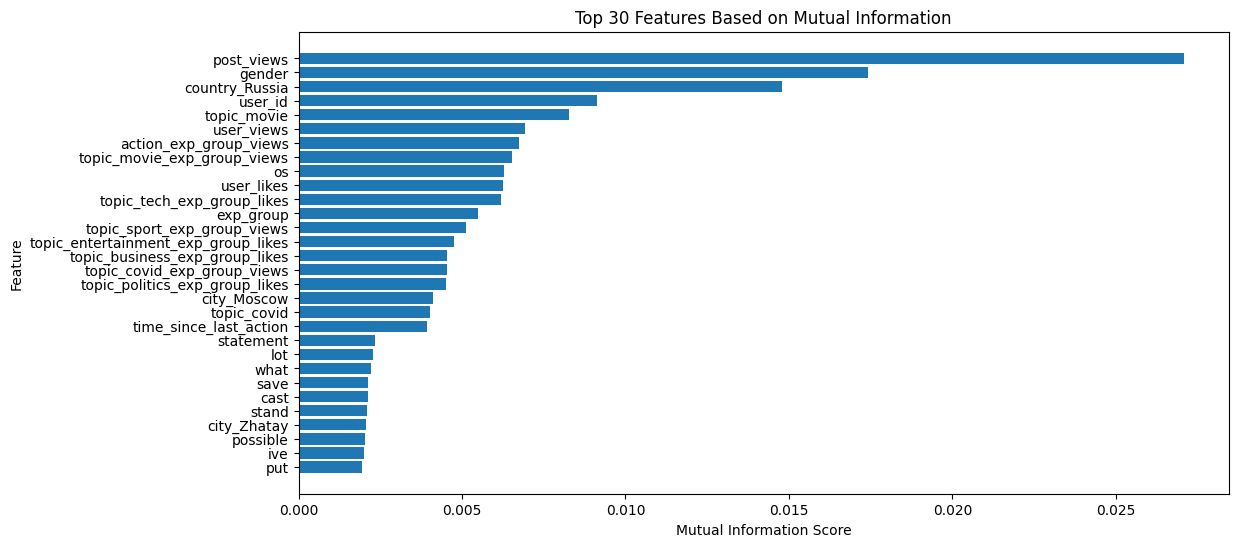

In [27]:
import matplotlib.pyplot as plt

# Set the number of top features to display
top_k = 30

# Get the top k features
top_k_features = mi_scores_df.head(top_k)

# Plot the top k features
plt.figure(figsize=(12, 6))
plt.barh(top_k_features['feature'], top_k_features['mi_score'], align='center')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Top {} Features Based on Mutual Information'.format(top_k))
plt.gca().invert_yaxis()
plt.show()


what if we rank the posts for each user by the number of likes and then use the rank as a feature? Also we can decrease the rank if the user already viewed the post.

# Model engineering

## Data preprocessing

We will use only the following features that we selected (`selected_features`) using the mutual information method:
`
'user_id', 'action', 'gender', 'age', 'exp_group', 'os', 'source',
       'day_of_week', 'time_since_last_action', 'country_Russia',
       'city_Kamyshlov', 'city_Moscow', 'city_Polatsk', 'city_Simferopol',
       'city_Tegul’det', 'city_Vyborg', 'topic_covid', 'topic_movie',
       'user_views', 'user_likes', 'post_views', 'post_likes',
       'topic_business_exp_group_likes', 'topic_covid_exp_group_views',
       'topic_entertainment_exp_group_likes', 'topic_movie_exp_group_views',
       'topic_politics_exp_group_likes', 'topic_sport_exp_group_views',
       'topic_tech_exp_group_likes', 'action_exp_group_views'`

In [34]:
df_top_k = data_with_tfidf[selected_features]
df_top_k.head()

,user_id,gender,exp_group,os,day_of_week,hour_of_day,time_since_last_action,country_Russia,city_Kansk,city_Kazan,...,opportunity,order,paid,party,past,political,robert,scene,seem,wanted
0,9612,1,0,0,1,14,0.0,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000
1,9612,1,0,0,1,14,79.0,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000
2,9612,1,0,0,1,14,2.0,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000
3,9612,1,0,0,1,14,46.0,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.043975
4,9612,1,0,0,1,14,148.0,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.12002,0.0,0.000000


### Train test split

In [68]:
# split the data into train and test
from sklearn.model_selection import train_test_split

# data with selected features, top k with mutual information, without data leakage, timestamp, 'action' and 'text'
X = data_with_tfidf[selected_features]
y = data_with_tfidf['target']

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [71]:
# Sort the train and test sets by 'group_id'
X_train = X_train.sort_values(by='group_id')
y_train = y_train.loc[X_train.index]

X_test = X_test.sort_values(by='group_id')
y_test = y_test.loc[X_test.index]

# Create train and test Pool objects with the 'group_id' column
from catboost import Pool

train_pool = Pool(X_train.drop(columns=['user_id']), y_train, group_id=X_train['group_id'])
test_pool = Pool(X_test.drop(columns=['user_id']), y_test, group_id=X_test['group_id'])

# Train the CatBoost model using PrecisionAt:top=5 evaluation metric
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.1,
                           depth=6,
                           custom_metric='PrecisionAt:top=5',
                           eval_metric='PrecisionAt:top=5',
                           random_seed=42,
                           verbose=100)

model.fit(train_pool, eval_set=test_pool)


0:	learn: 0.0633929	test: 0.0366071	best: 0.0366071 (0)	total: 10ms	remaining: 10s
100:	learn: 0.3803571	test: 0.1973214	best: 0.2035714 (33)	total: 791ms	remaining: 7.04s
200:	learn: 0.5241071	test: 0.1982143	best: 0.2071429 (150)	total: 1.58s	remaining: 6.26s
300:	learn: 0.6053571	test: 0.1883929	best: 0.2071429 (150)	total: 2.34s	remaining: 5.44s
400:	learn: 0.6705357	test: 0.1883929	best: 0.2071429 (150)	total: 3.09s	remaining: 4.62s
500:	learn: 0.7303571	test: 0.1821429	best: 0.2071429 (150)	total: 3.85s	remaining: 3.83s
600:	learn: 0.7732143	test: 0.1794643	best: 0.2071429 (150)	total: 4.6s	remaining: 3.05s
700:	learn: 0.8062500	test: 0.1705357	best: 0.2071429 (150)	total: 5.35s	remaining: 2.28s
800:	learn: 0.8312500	test: 0.1660714	best: 0.2071429 (150)	total: 6.1s	remaining: 1.51s
900:	learn: 0.8544643	test: 0.1669643	best: 0.2071429 (150)	total: 6.85s	remaining: 753ms
999:	learn: 0.8705357	test: 0.1562500	best: 0.2071429 (150)	total: 7.59s	remaining: 0us

bestTest = 0.20714285

In this case, the best Precision@5 score for the test set is 0.2071428571. This means that, on average, about 20.71% of the top 5 predicted items are true positives.


In [89]:
model.save_model('catboost_model.cbm')

In [90]:
from_file = CatBoostClassifier()
from_file.load_model('catboost_model.cbm')
from_file.predict(test_pool)

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)